## TC3007B
### Word Embeddings

<br>

#### Activity 2: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


# Team Members:
 - Javier Suarez Duran - A01707380
 - Jaime Lopez Hernández - A00571842
 - Diego Alfonso Ramírez Montes - A01707596
 - Ricardo Andrés Cáceres Villibord - A01706972

Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
!pip install torch torchtext
!pip install torchdata torchvision torchaudio -f https://download.pytorch.org/whl/cu102/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


In [2]:
!pip install scikit-plot
!pip install portalocker

In [3]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [4]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [6]:
vocab_len = 98635

In [7]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [8]:
# Get the tokeniser
# tokeniser object
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokenizer(text)

In [9]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [10]:
#test tokens
tokens = tokenizer('Welcome to TC3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc3007'] [3314, 4, 0]


In [11]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [12]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [13]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [14]:
def collate_batch(batch):
    # Unzip the batch into labels (y) and text (x)
    y, x = list(zip(*batch))

    # Tokenize each text using the tokenizer
    x = [vocab(tokenizer(text)) for text in x]

    # Pad each token sequence to max_tokens length
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Subtract 1 from labels to put them in 0-3 range
    y = torch.tensor(y, dtype=torch.int32) - 1

    # Convert labels to 1D tensor
    # Convert token sequences to tensors
    return torch.tensor(x, dtype=torch.int32), y

In [15]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [44]:
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

In [18]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()

        # Create an embedding layer with vocab size and embedding dim
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)

        # Create a GRU with input size equal to embedding dim, hidden size, and number of layers
        self.gru = nn.GRU(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)

        # Fully connected layer to transform final hidden state to output dim
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):

        # Apply embedding layer to input
        embedded = self.embedding_layer(x)

        # Get GRU outputs and final hidden state
        output, hidden = self.gru(embedded)

        # Use final hidden state for classification
        output = self.fc(hidden[-1])

        return output

rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)

In [19]:
for l in rnn_model.children():
  print(f'Layer: {l}: ')
  for p in l.parameters():
    print(f'\t{p.shape}')
  print()

Layer: Embedding(95811, 300): 
	torch.Size([95811, 300])

Layer: GRU(300, 256, num_layers=2, batch_first=True): 
	torch.Size([768, 300])
	torch.Size([768, 256])
	torch.Size([768])
	torch.Size([768])
	torch.Size([768, 256])
	torch.Size([768, 256])
	torch.Size([768])
	torch.Size([768])

Layer: Linear(in_features=256, out_features=4, bias=True): 
	torch.Size([4, 256])
	torch.Size([4])



In [20]:
# Perform inference
output = rnn_model(torch.randint(low=0, high=len(vocab), size=(1, max_tokens)))
print(output.shape)

torch.Size([1, 4])


In [45]:
def accuracy(model, loader):

    # Set model to evaluation mode
    model.eval()
    model = model.to(device = device)

    # Number of correct predictions
    num_correct = 0
    # Total number of predictions
    num_total = 0

    # No need to calculate gradients when evaluating
    with torch.no_grad():

        # Iterate through data loader
        for x, y in loader:

            # Move batch to device (CPU/GPU)
            x = x.to(device = device, dtype = torch.long)
            y = y.to(device = device, dtype = torch.long)

            # Get prediction scores
            scores = model(x)

            # Get predictions by taking maximum score
            _, preds = scores.max(dim = 1)

            # Update number of correct and total predictions
            num_correct += (preds == y).sum()
            num_total+= preds.size(0)

        # Calculate accuracy as number correct / total
        acc = float(num_correct)/num_total

    return acc

In [22]:
from tqdm import tqdm

In [46]:
def train(model, optimizer, scheduler=None, epochs=100):

    # Move model to GPU/CPU
    model = model.to(device=device)

    for epoch in range(epochs):

        total_loss = 0.0

        # Set model to training mode
        model.train()

        for i, (x, y) in enumerate(tqdm(train_loader)):

            # Move batch to device
            x = x.to(device=device, dtype=torch.long)
            y = y.to(device=device, dtype=torch.long)

            # Forward pass
            scores = model(x)
            # Calculate loss
            loss = F.cross_entropy(input=scores, target=y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track total loss
            total_loss += loss.item()

        # Update learning rate scheduler
        if scheduler:
            scheduler.step()

        # Evaluate validation accuracy
        val_acc = accuracy(model, val_loader)

        # Print metrics
        print(f'Epoch: {epoch}, Training Loss: {total_loss / len(train_loader):.4f}, Validation Accuracy: {val_acc:.4f}')

In [24]:
# Define the number of epochs
epochs = 1

# Define the learning rate
lr = 0.001
# Move the model to the device if needed
gru_model = rnn_model.to(device=device)

# Set up the optimizer
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [25]:
#Training GRU_Model_1
train(rnn_model, optimizer=optimizer,  epochs=epochs)

  0%|          | 0/422 [00:00<?, ?it/s]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  0%|          | 1/422 [00:02<20:06,  2.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  0%|          | 2/422 [00:04<15:57,  2.28s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  1%|          | 3/422 [00:06<14:51,  2.13s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  1%|          | 4/422 [00:09<15:59,  2.30s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  1%|          | 5/422 [00:11<16:11,  2.33s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  1%|▏         | 6/422 [00:14<17:03,  2.46s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  2%|▏         | 7/422 [00:16<16:38,  2.41s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  2%|▏         | 8/422 [00:18<15:19,  2.22s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  2%|▏         | 9/422 [00:20<14:30,  2.11s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  2%|▏         | 10/422 [00:22<13:58,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  3%|▎         | 11/422 [00:23<13:24,  1.96s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  3%|▎         | 12/422 [00:25<13:03,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  3%|▎         | 13/422 [00:28<14:34,  2.14s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  3%|▎         | 14/422 [00:30<14:46,  2.17s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  4%|▎         | 15/422 [00:32<14:05,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  4%|▍         | 16/422 [00:34<13:32,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  4%|▍         | 17/422 [00:36<13:08,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  4%|▍         | 18/422 [00:37<12:46,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  5%|▍         | 19/422 [00:39<12:32,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  5%|▍         | 20/422 [00:42<14:04,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  5%|▍         | 21/422 [00:45<16:35,  2.48s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  5%|▌         | 22/422 [00:48<17:19,  2.60s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  5%|▌         | 23/422 [00:50<15:40,  2.36s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  6%|▌         | 24/422 [00:52<14:32,  2.19s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  6%|▌         | 25/422 [00:54<13:45,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  6%|▌         | 26/422 [00:56<14:58,  2.27s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  6%|▋         | 27/422 [00:59<15:01,  2.28s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  7%|▋         | 28/422 [01:00<13:59,  2.13s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  7%|▋         | 29/422 [01:02<13:19,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  7%|▋         | 30/422 [01:04<12:47,  1.96s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  7%|▋         | 31/422 [01:06<12:27,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  8%|▊         | 32/422 [01:08<12:09,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  8%|▊         | 33/422 [01:10<13:32,  2.09s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  8%|▊         | 34/422 [01:12<14:00,  2.17s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  8%|▊         | 35/422 [01:14<13:15,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  9%|▊         | 36/422 [01:16<12:42,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  9%|▉         | 37/422 [01:18<12:20,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  9%|▉         | 38/422 [01:20<12:09,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  9%|▉         | 39/422 [01:22<11:59,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


  9%|▉         | 40/422 [01:24<13:17,  2.09s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 10%|▉         | 41/422 [01:27<14:31,  2.29s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 10%|▉         | 42/422 [01:29<13:35,  2.15s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 10%|█         | 43/422 [01:31<12:54,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 10%|█         | 44/422 [01:34<14:47,  2.35s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 11%|█         | 45/422 [01:40<21:52,  3.48s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 11%|█         | 46/422 [01:44<22:31,  3.60s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 11%|█         | 47/422 [01:45<19:05,  3.05s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 11%|█▏        | 48/422 [01:47<16:42,  2.68s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 12%|█▏        | 49/422 [01:49<14:58,  2.41s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 12%|█▏        | 50/422 [01:51<13:50,  2.23s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 12%|█▏        | 51/422 [01:53<14:37,  2.37s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 12%|█▏        | 52/422 [01:56<14:17,  2.32s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 13%|█▎        | 53/422 [01:57<13:16,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 13%|█▎        | 54/422 [01:59<12:31,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 13%|█▎        | 55/422 [02:01<11:59,  1.96s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 13%|█▎        | 56/422 [02:03<11:42,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 14%|█▎        | 57/422 [02:05<11:30,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 14%|█▎        | 58/422 [02:07<12:51,  2.12s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 14%|█▍        | 59/422 [02:10<13:05,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 14%|█▍        | 60/422 [02:11<12:22,  2.05s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 14%|█▍        | 61/422 [02:13<11:49,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 15%|█▍        | 62/422 [02:15<11:26,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 15%|█▍        | 63/422 [02:17<11:15,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 15%|█▌        | 64/422 [02:18<11:01,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 15%|█▌        | 65/422 [02:21<12:15,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 16%|█▌        | 66/422 [02:23<12:49,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 16%|█▌        | 67/422 [02:25<12:10,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 16%|█▌        | 68/422 [02:27<11:41,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 16%|█▋        | 69/422 [02:29<11:24,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 17%|█▋        | 70/422 [02:31<11:07,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 17%|█▋        | 71/422 [02:32<10:55,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 17%|█▋        | 72/422 [02:35<11:59,  2.05s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 17%|█▋        | 73/422 [02:37<12:34,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 18%|█▊        | 74/422 [02:39<11:56,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 18%|█▊        | 75/422 [02:41<11:25,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 18%|█▊        | 76/422 [02:43<11:07,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 18%|█▊        | 77/422 [02:45<10:55,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 18%|█▊        | 78/422 [02:46<10:41,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 19%|█▊        | 79/422 [02:49<11:38,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 19%|█▉        | 80/422 [02:51<12:24,  2.18s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 19%|█▉        | 81/422 [02:53<11:42,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 19%|█▉        | 82/422 [02:55<11:16,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 20%|█▉        | 83/422 [02:57<10:54,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 20%|█▉        | 84/422 [02:59<10:42,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 20%|██        | 85/422 [03:00<10:31,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 20%|██        | 86/422 [03:03<11:19,  2.02s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 21%|██        | 87/422 [03:05<12:13,  2.19s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 21%|██        | 88/422 [03:07<11:31,  2.07s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 21%|██        | 89/422 [03:09<11:02,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 21%|██▏       | 90/422 [03:11<10:42,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 22%|██▏       | 91/422 [03:13<10:24,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 22%|██▏       | 92/422 [03:14<10:14,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 22%|██▏       | 93/422 [03:17<10:56,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 22%|██▏       | 94/422 [03:19<11:56,  2.18s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 23%|██▎       | 95/422 [03:21<11:18,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 23%|██▎       | 96/422 [03:23<10:46,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 23%|██▎       | 97/422 [03:25<10:22,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 23%|██▎       | 98/422 [03:26<10:06,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 23%|██▎       | 99/422 [03:28<10:00,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 24%|██▎       | 100/422 [03:31<11:52,  2.21s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 24%|██▍       | 101/422 [03:34<12:09,  2.27s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 24%|██▍       | 102/422 [03:35<11:20,  2.13s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 24%|██▍       | 103/422 [03:37<10:46,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 25%|██▍       | 104/422 [03:39<10:20,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 25%|██▍       | 105/422 [03:41<10:05,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 25%|██▌       | 106/422 [03:43<09:52,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 25%|██▌       | 107/422 [03:45<10:27,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 26%|██▌       | 108/422 [03:47<11:20,  2.17s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 26%|██▌       | 109/422 [03:49<10:46,  2.07s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 26%|██▌       | 110/422 [03:51<10:15,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 26%|██▋       | 111/422 [03:53<09:53,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 27%|██▋       | 112/422 [03:55<09:39,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 27%|██▋       | 113/422 [03:56<09:29,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 27%|██▋       | 114/422 [03:58<09:54,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 27%|██▋       | 115/422 [04:01<10:58,  2.15s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 27%|██▋       | 116/422 [04:03<10:29,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 28%|██▊       | 117/422 [04:05<10:02,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 28%|██▊       | 118/422 [04:07<09:45,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 28%|██▊       | 119/422 [04:08<09:30,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 28%|██▊       | 120/422 [04:10<09:18,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 29%|██▊       | 121/422 [04:12<09:28,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 29%|██▉       | 122/422 [04:15<10:24,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 29%|██▉       | 123/422 [04:17<10:18,  2.07s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 29%|██▉       | 124/422 [04:18<09:47,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 30%|██▉       | 125/422 [04:20<09:32,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 30%|██▉       | 126/422 [04:22<09:15,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 30%|███       | 127/422 [04:24<09:08,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 30%|███       | 128/422 [04:26<09:09,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 31%|███       | 129/422 [04:28<10:17,  2.11s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 31%|███       | 130/422 [04:30<10:15,  2.11s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 31%|███       | 131/422 [04:32<09:42,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 31%|███▏      | 132/422 [04:34<09:18,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 32%|███▏      | 133/422 [04:36<09:02,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 32%|███▏      | 134/422 [04:37<08:49,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 32%|███▏      | 135/422 [04:39<08:41,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 32%|███▏      | 136/422 [04:42<09:39,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 32%|███▏      | 137/422 [04:44<09:58,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 33%|███▎      | 138/422 [04:46<09:27,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 33%|███▎      | 139/422 [04:48<09:04,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 33%|███▎      | 140/422 [04:49<08:47,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 33%|███▎      | 141/422 [04:51<08:38,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 34%|███▎      | 142/422 [04:53<08:28,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 34%|███▍      | 143/422 [04:55<09:11,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 34%|███▍      | 144/422 [04:58<09:55,  2.14s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 34%|███▍      | 145/422 [05:00<09:24,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 35%|███▍      | 146/422 [05:01<08:58,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 35%|███▍      | 147/422 [05:03<08:41,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 35%|███▌      | 148/422 [05:05<08:28,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 35%|███▌      | 149/422 [05:07<08:17,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 36%|███▌      | 150/422 [05:10<10:56,  2.41s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 36%|███▌      | 151/422 [05:14<13:13,  2.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 36%|███▌      | 152/422 [05:18<13:34,  3.02s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 36%|███▋      | 153/422 [05:19<11:48,  2.63s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 36%|███▋      | 154/422 [05:21<10:39,  2.38s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 37%|███▋      | 155/422 [05:23<10:03,  2.26s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 37%|███▋      | 156/422 [05:26<10:25,  2.35s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 37%|███▋      | 157/422 [05:28<09:53,  2.24s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 37%|███▋      | 158/422 [05:29<09:09,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 38%|███▊      | 159/422 [05:31<08:39,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 38%|███▊      | 160/422 [05:33<08:20,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 38%|███▊      | 161/422 [05:35<08:07,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 38%|███▊      | 162/422 [05:37<08:01,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 39%|███▊      | 163/422 [05:39<08:55,  2.07s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 39%|███▉      | 164/422 [05:41<09:05,  2.11s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 39%|███▉      | 165/422 [05:43<08:35,  2.01s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 39%|███▉      | 166/422 [05:45<08:17,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 40%|███▉      | 167/422 [05:47<08:03,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 40%|███▉      | 168/422 [05:48<07:56,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 40%|████      | 169/422 [05:50<07:46,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 40%|████      | 170/422 [05:53<08:32,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 41%|████      | 171/422 [05:55<08:57,  2.14s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 41%|████      | 172/422 [05:57<08:30,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 41%|████      | 173/422 [05:59<08:12,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 41%|████      | 174/422 [06:01<08:00,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 41%|████▏     | 175/422 [06:02<07:48,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 42%|████▏     | 176/422 [06:04<07:38,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 42%|████▏     | 177/422 [06:07<08:14,  2.02s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 42%|████▏     | 178/422 [06:09<08:44,  2.15s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 42%|████▏     | 179/422 [06:11<08:16,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 43%|████▎     | 180/422 [06:13<07:57,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 43%|████▎     | 181/422 [06:14<07:40,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 43%|████▎     | 182/422 [06:16<07:26,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 43%|████▎     | 183/422 [06:18<07:16,  1.83s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 44%|████▎     | 184/422 [06:20<07:48,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 44%|████▍     | 185/422 [06:23<08:38,  2.19s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 44%|████▍     | 186/422 [06:25<08:07,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 44%|████▍     | 187/422 [06:26<07:46,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 45%|████▍     | 188/422 [06:28<07:29,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 45%|████▍     | 189/422 [06:30<07:15,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 45%|████▌     | 190/422 [06:32<07:04,  1.83s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 45%|████▌     | 191/422 [06:34<07:16,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 45%|████▌     | 192/422 [06:36<08:06,  2.12s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 46%|████▌     | 193/422 [06:38<07:51,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 46%|████▌     | 194/422 [06:40<07:32,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 46%|████▌     | 195/422 [06:42<07:19,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 46%|████▋     | 196/422 [06:44<07:06,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 47%|████▋     | 197/422 [06:46<06:59,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 47%|████▋     | 198/422 [06:47<06:59,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 47%|████▋     | 199/422 [06:50<07:43,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 47%|████▋     | 200/422 [06:52<07:41,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 48%|████▊     | 201/422 [06:54<07:21,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 48%|████▊     | 202/422 [06:56<07:05,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 48%|████▊     | 203/422 [06:57<06:53,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 48%|████▊     | 204/422 [06:59<06:43,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 49%|████▊     | 205/422 [07:01<06:34,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 49%|████▉     | 206/422 [07:04<07:24,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 49%|████▉     | 207/422 [07:06<07:31,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 49%|████▉     | 208/422 [07:07<07:05,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 50%|████▉     | 209/422 [07:09<06:47,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 50%|████▉     | 210/422 [07:11<06:33,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 50%|█████     | 211/422 [07:13<06:22,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 50%|█████     | 212/422 [07:14<06:13,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 50%|█████     | 213/422 [07:17<06:42,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 51%|█████     | 214/422 [07:19<07:19,  2.11s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 51%|█████     | 215/422 [07:21<06:55,  2.01s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 51%|█████     | 216/422 [07:23<06:36,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 51%|█████▏    | 217/422 [07:24<06:22,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 52%|█████▏    | 218/422 [07:26<06:13,  1.83s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 52%|█████▏    | 219/422 [07:28<06:04,  1.80s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 52%|█████▏    | 220/422 [07:30<06:14,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 52%|█████▏    | 221/422 [07:32<06:58,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 53%|█████▎    | 222/422 [07:34<06:48,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 53%|█████▎    | 223/422 [07:36<06:28,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 53%|█████▎    | 224/422 [07:38<06:12,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 53%|█████▎    | 225/422 [07:40<05:58,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 54%|█████▎    | 226/422 [07:41<05:49,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 54%|█████▍    | 227/422 [07:43<05:43,  1.76s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 54%|█████▍    | 228/422 [07:45<06:23,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 54%|█████▍    | 229/422 [07:48<06:39,  2.07s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 55%|█████▍    | 230/422 [07:49<06:15,  1.96s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 55%|█████▍    | 231/422 [07:51<06:02,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 55%|█████▍    | 232/422 [07:53<05:51,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 55%|█████▌    | 233/422 [07:55<05:44,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 55%|█████▌    | 234/422 [07:56<05:42,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 56%|█████▌    | 235/422 [07:59<06:02,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 56%|█████▌    | 236/422 [08:01<06:30,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 56%|█████▌    | 237/422 [08:03<06:08,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 56%|█████▋    | 238/422 [08:05<05:52,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 57%|█████▋    | 239/422 [08:06<05:40,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 57%|█████▋    | 240/422 [08:08<05:31,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 57%|█████▋    | 241/422 [08:10<05:24,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 57%|█████▋    | 242/422 [08:12<05:24,  1.80s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 58%|█████▊    | 243/422 [08:14<06:03,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 58%|█████▊    | 244/422 [08:16<06:01,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 58%|█████▊    | 245/422 [08:18<05:43,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 58%|█████▊    | 246/422 [08:20<05:29,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 59%|█████▊    | 247/422 [08:21<05:21,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 59%|█████▉    | 248/422 [08:23<05:14,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 59%|█████▉    | 249/422 [08:25<05:09,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 59%|█████▉    | 250/422 [08:27<05:41,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 59%|█████▉    | 251/422 [08:30<06:00,  2.11s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 60%|█████▉    | 252/422 [08:32<05:42,  2.02s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 60%|█████▉    | 253/422 [08:33<05:30,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 60%|██████    | 254/422 [08:35<05:21,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 60%|██████    | 255/422 [08:37<05:13,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 61%|██████    | 256/422 [08:39<05:07,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 61%|██████    | 257/422 [08:41<05:32,  2.01s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 61%|██████    | 258/422 [08:44<05:54,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 61%|██████▏   | 259/422 [08:45<05:32,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 62%|██████▏   | 260/422 [08:47<05:19,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 62%|██████▏   | 261/422 [08:49<05:07,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 62%|██████▏   | 262/422 [08:51<04:59,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 62%|██████▏   | 263/422 [08:53<04:53,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 63%|██████▎   | 264/422 [08:55<05:14,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 63%|██████▎   | 265/422 [08:57<05:38,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 63%|██████▎   | 266/422 [08:59<05:19,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 63%|██████▎   | 267/422 [09:01<05:01,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 64%|██████▎   | 268/422 [09:03<04:52,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 64%|██████▎   | 269/422 [09:05<04:44,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 64%|██████▍   | 270/422 [09:06<04:40,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 64%|██████▍   | 271/422 [09:08<04:47,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 64%|██████▍   | 272/422 [09:11<05:17,  2.12s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 65%|██████▍   | 273/422 [09:13<05:06,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 65%|██████▍   | 274/422 [09:15<04:50,  1.96s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 65%|██████▌   | 275/422 [09:16<04:41,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 65%|██████▌   | 276/422 [09:18<04:35,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 66%|██████▌   | 277/422 [09:20<04:29,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 66%|██████▌   | 278/422 [09:22<04:30,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 66%|██████▌   | 279/422 [09:25<05:00,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 66%|██████▋   | 280/422 [09:27<04:55,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 67%|██████▋   | 281/422 [09:28<04:41,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 67%|██████▋   | 282/422 [09:30<04:29,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 67%|██████▋   | 283/422 [09:32<04:19,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 67%|██████▋   | 284/422 [09:34<04:13,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 68%|██████▊   | 285/422 [09:35<04:08,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 68%|██████▊   | 286/422 [09:38<04:37,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 68%|██████▊   | 287/422 [09:40<04:40,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 68%|██████▊   | 288/422 [09:42<04:25,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 68%|██████▊   | 289/422 [09:44<04:13,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 69%|██████▊   | 290/422 [09:45<04:05,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 69%|██████▉   | 291/422 [09:47<03:57,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 69%|██████▉   | 292/422 [09:49<03:51,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 69%|██████▉   | 293/422 [09:51<04:07,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 70%|██████▉   | 294/422 [09:54<04:27,  2.09s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 70%|██████▉   | 295/422 [09:55<04:11,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 70%|███████   | 296/422 [09:57<04:01,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 70%|███████   | 297/422 [09:59<03:52,  1.86s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 71%|███████   | 298/422 [10:00<03:44,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 71%|███████   | 299/422 [10:02<03:41,  1.80s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 71%|███████   | 300/422 [10:04<03:44,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 71%|███████▏  | 301/422 [10:07<04:08,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 72%|███████▏  | 302/422 [10:09<04:04,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 72%|███████▏  | 303/422 [10:10<03:52,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 72%|███████▏  | 304/422 [10:12<03:43,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 72%|███████▏  | 305/422 [10:14<03:35,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 73%|███████▎  | 306/422 [10:16<03:30,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 73%|███████▎  | 307/422 [10:17<03:25,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 73%|███████▎  | 308/422 [10:20<03:48,  2.01s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 73%|███████▎  | 309/422 [10:22<03:55,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 73%|███████▎  | 310/422 [10:24<03:42,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 74%|███████▎  | 311/422 [10:26<03:31,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 74%|███████▍  | 312/422 [10:27<03:24,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 74%|███████▍  | 313/422 [10:29<03:16,  1.80s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 74%|███████▍  | 314/422 [10:31<03:12,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 75%|███████▍  | 315/422 [10:33<03:25,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 75%|███████▍  | 316/422 [10:36<03:42,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 75%|███████▌  | 317/422 [10:37<03:29,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 75%|███████▌  | 318/422 [10:39<03:18,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 76%|███████▌  | 319/422 [10:41<03:10,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 76%|███████▌  | 320/422 [10:42<03:04,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 76%|███████▌  | 321/422 [10:44<03:00,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 76%|███████▋  | 322/422 [10:46<03:02,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 77%|███████▋  | 323/422 [10:49<03:23,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 77%|███████▋  | 324/422 [10:51<03:19,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 77%|███████▋  | 325/422 [10:52<03:08,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 77%|███████▋  | 326/422 [10:54<03:00,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 77%|███████▋  | 327/422 [10:56<02:54,  1.83s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 78%|███████▊  | 328/422 [10:58<02:50,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 78%|███████▊  | 329/422 [10:59<02:46,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 78%|███████▊  | 330/422 [11:02<03:03,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 78%|███████▊  | 331/422 [11:04<03:09,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 79%|███████▊  | 332/422 [11:06<02:58,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 79%|███████▉  | 333/422 [11:08<02:49,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 79%|███████▉  | 334/422 [11:09<02:42,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 79%|███████▉  | 335/422 [11:11<02:37,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 80%|███████▉  | 336/422 [11:13<02:34,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 80%|███████▉  | 337/422 [11:15<02:41,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 80%|████████  | 338/422 [11:17<02:55,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 80%|████████  | 339/422 [11:19<02:45,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 81%|████████  | 340/422 [11:21<02:37,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 81%|████████  | 341/422 [11:23<02:31,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 81%|████████  | 342/422 [11:25<02:27,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 81%|████████▏ | 343/422 [11:26<02:24,  1.82s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 82%|████████▏ | 344/422 [11:28<02:23,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 82%|████████▏ | 345/422 [11:31<02:37,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 82%|████████▏ | 346/422 [11:33<02:34,  2.04s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 82%|████████▏ | 347/422 [11:34<02:25,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 82%|████████▏ | 348/422 [11:36<02:19,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 83%|████████▎ | 349/422 [11:38<02:14,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 83%|████████▎ | 350/422 [11:40<02:08,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 83%|████████▎ | 351/422 [11:41<02:06,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 83%|████████▎ | 352/422 [11:44<02:19,  1.99s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 84%|████████▎ | 353/422 [11:46<02:24,  2.10s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 84%|████████▍ | 354/422 [11:48<02:15,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 84%|████████▍ | 355/422 [11:50<02:09,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 84%|████████▍ | 356/422 [11:51<02:03,  1.88s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 85%|████████▍ | 357/422 [11:53<01:58,  1.83s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 85%|████████▍ | 358/422 [11:55<01:55,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 85%|████████▌ | 359/422 [11:57<02:02,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 85%|████████▌ | 360/422 [12:00<02:11,  2.12s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 86%|████████▌ | 361/422 [12:02<02:02,  2.01s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 86%|████████▌ | 362/422 [12:03<01:56,  1.94s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 86%|████████▌ | 363/422 [12:05<01:51,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 86%|████████▋ | 364/422 [12:07<01:47,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 86%|████████▋ | 365/422 [12:09<01:43,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 87%|████████▋ | 366/422 [12:11<01:47,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 87%|████████▋ | 367/422 [12:13<01:56,  2.12s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 87%|████████▋ | 368/422 [12:15<01:50,  2.05s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 87%|████████▋ | 369/422 [12:17<01:44,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 88%|████████▊ | 370/422 [12:19<01:39,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 88%|████████▊ | 371/422 [12:21<01:35,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 88%|████████▊ | 372/422 [12:23<01:43,  2.07s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 88%|████████▊ | 373/422 [12:27<02:13,  2.72s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 89%|████████▊ | 374/422 [12:31<02:23,  2.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 89%|████████▉ | 375/422 [12:33<02:02,  2.60s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 89%|████████▉ | 376/422 [12:34<01:48,  2.35s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 89%|████████▉ | 377/422 [12:36<01:37,  2.16s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 90%|████████▉ | 378/422 [12:38<01:29,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 90%|████████▉ | 379/422 [12:40<01:28,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 90%|█████████ | 380/422 [12:42<01:32,  2.20s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 90%|█████████ | 381/422 [12:44<01:24,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 91%|█████████ | 382/422 [12:46<01:17,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 91%|█████████ | 383/422 [12:48<01:13,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 91%|█████████ | 384/422 [12:49<01:09,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 91%|█████████ | 385/422 [12:51<01:06,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 91%|█████████▏| 386/422 [12:53<01:03,  1.77s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 92%|█████████▏| 387/422 [12:55<01:09,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 92%|█████████▏| 388/422 [12:57<01:09,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 92%|█████████▏| 389/422 [12:59<01:04,  1.95s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 92%|█████████▏| 390/422 [13:01<01:00,  1.89s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 93%|█████████▎| 391/422 [13:03<00:57,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 93%|█████████▎| 392/422 [13:04<00:54,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 93%|█████████▎| 393/422 [13:06<00:51,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 93%|█████████▎| 394/422 [13:08<00:53,  1.91s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 94%|█████████▎| 395/422 [13:11<00:56,  2.08s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 94%|█████████▍| 396/422 [13:12<00:51,  1.97s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 94%|█████████▍| 397/422 [13:14<00:47,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 94%|█████████▍| 398/422 [13:16<00:44,  1.85s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 95%|█████████▍| 399/422 [13:18<00:41,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 95%|█████████▍| 400/422 [13:19<00:39,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 95%|█████████▌| 401/422 [13:21<00:37,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 95%|█████████▌| 402/422 [13:24<00:40,  2.03s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 95%|█████████▌| 403/422 [13:26<00:38,  2.02s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 96%|█████████▌| 404/422 [13:27<00:34,  1.93s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 96%|█████████▌| 405/422 [13:29<00:31,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 96%|█████████▌| 406/422 [13:31<00:29,  1.83s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 96%|█████████▋| 407/422 [13:33<00:27,  1.81s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 97%|█████████▋| 408/422 [13:34<00:24,  1.78s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 97%|█████████▋| 409/422 [13:37<00:25,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 97%|█████████▋| 410/422 [13:39<00:25,  2.09s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 97%|█████████▋| 411/422 [13:41<00:21,  1.98s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 98%|█████████▊| 412/422 [13:43<00:19,  1.90s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 98%|█████████▊| 413/422 [13:44<00:16,  1.84s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 98%|█████████▊| 414/422 [13:46<00:14,  1.80s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 98%|█████████▊| 415/422 [13:48<00:12,  1.79s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 99%|█████████▊| 416/422 [13:50<00:11,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 99%|█████████▉| 417/422 [13:52<00:10,  2.06s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 99%|█████████▉| 418/422 [13:54<00:07,  2.00s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


 99%|█████████▉| 419/422 [13:56<00:05,  1.92s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


100%|█████████▉| 420/422 [13:58<00:03,  1.87s/it]

Model Output Shape: torch.Size([256, 4])
Target Shape: torch.Size([256])


100%|█████████▉| 421/422 [13:59<00:01,  1.83s/it]

Model Output Shape: torch.Size([224, 4])
Target Shape: torch.Size([224])


100%|██████████| 422/422 [14:01<00:00,  1.99s/it]


Epoch: 0, Training Loss: 0.5432, Validation Accuracy: 0.8947


In [26]:
# Save the model
torch.save(rnn_model.state_dict(), 'rnn_model.pth')

In [27]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.8889


In [36]:
def sample_text(model, text):
    model.eval()
    tokenized_text = tokenizer(text)
    indexed_tokens = [vocab[token] for token in tokenized_text]
    tensor = torch.LongTensor(indexed_tokens).unsqueeze(0).to(device)  # Convert the tokenized text to a tensor using the vocabulary
    with torch.no_grad():
        output = model(tensor)
        _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()
    return predicted_class

In [48]:
sampled_class = sample_text(rnn_model, "Badmington")
print(f"The predicted class for the sample text is: {sampled_class}")

The predicted class for the sample text is: 2


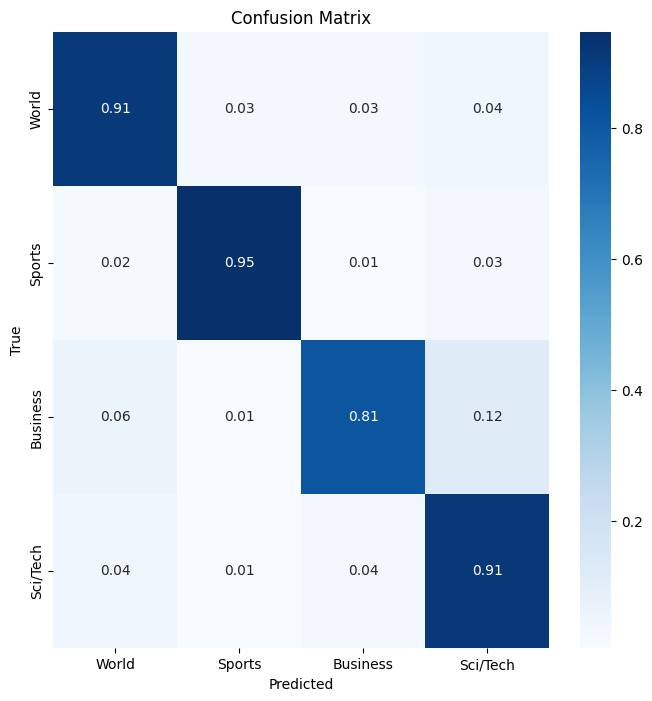

In [29]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to evaluate the model and plot the confusion matrix
def evaluate_and_plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    plot_confusion_matrix(all_labels, all_predictions, classes)


labels = ["World", "Sports", "Business", "Sci/Tech"]

# Evaluate and plot confusion matrix on the validation set
evaluate_and_plot_confusion_matrix(rnn_model, val_loader, labels)
